In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *

Loading imports


In [3]:
torch.cuda.set_device(4)

## Load Model

In [4]:
class Transfusion(nn.Module):
    def __init__(self, channels, ks=7):
        super().__init__()
        layers = []
        ks = [ks]*len(channels) if isinstance(ks, int) else ks
        l_args = zip(channels, ks)
        for (c_in,c_out),k in l_args: layers += [ConvLayer(c_in, c_out, ks=k), nn.MaxPool2d(3, stride=2, padding=1)]
        self.body = nn.Sequential(*layers)
        self.head = nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(channels[-1][-1], 6)
        ])
        
    def forward(self, x):
        return self.head(self.body(x))

In [5]:
# model = xresnet18(c_in=4)

In [6]:
def t_large():
    chs = [(3,32), (32, 64), (64, 128), (128, 256), (256, 512)]
    return Transfusion(chs, ks=7)

In [7]:
def t_tiny():
    chs = [(3,64), (64, 128), (128, 256), (256, 512)]
    return Transfusion(chs, ks=5)

In [8]:
def t_med():
    chs = [(3,32), (32, 64), (64, 128), (128, 256), (256, 512)]
    return Transfusion(chs, ks=(7,3,3,5,5))

In [9]:
m = t_tiny()

In [10]:
# m = xresnet18(c_out=6) # 2:50 per epoch

In [11]:
name = 'baseline_any_transfusion'

In [12]:
dbch = get_data(512, 128, splits=Meta.splits_stg1)
learn = get_learner(dbch, m)

In [13]:
learn.model

Transfusion(
  (body): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ConvLayer(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ConvLayer(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): ConvLayer(
      (0): Conv2d

## Training

In [14]:
# learn.lr_find()

In [15]:
do_fit(learn, 12, 4e-2)
learn.save(f'runs/{name}-1')

In [16]:
learn.dls = get_data(256, 256, splits=Meta.splits_stg1)
learn.load(f'runs/{name}-1')

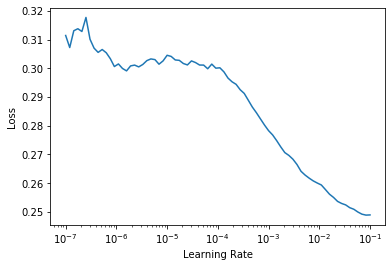

In [23]:
learn.lr_find()

In [17]:
do_fit(learn, 12, 4e-3)
learn.save(f'runs/{name}-2')

In [13]:
learn.load(f'runs/{name}-2')
learn.dls = get_data(128, 384, splits=Meta.splits_stg1, img_dir=path_jpg)
do_fit(learn, 4, 4e-4)
learn.save(f'runs/{name}-3')

## Submission

In [14]:
learn.load(f'runs/{name}-3')
sub_fn = f'subm/{name}'

In [15]:
learn.dls = get_test_data(Meta.df_tst, bs=128, sz=384)

In [16]:
ob = learn.dls.one_batch()

In [17]:
preds,targs = learn.get_preds()

In [18]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [19]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 10.5MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [21]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14336674,
 'totalBytes': 27277209,
 'date': '2020-01-30T20:34:41.17Z',
 'description': 'baseline_any_transfusion',
 'errorDescription': None,
 'fileName': 'baseline_any_transfusion.csv',
 'publicScore': '0.22696',
 'privateScore': '0.07972',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14336674/14336674.raw'}